In [1]:
# ===================== IMPORTS/LIBRARIES =====================

import tensorflow as tf
from mtcnn import MTCNN
from pathlib import Path
import pandas as pd
import glob
import cv2
import numpy as np
import csv
import os
import ast
import pydot
import pydotplus
import graphviz
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import tensorflow_addons as tfa

import time

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback

C:\Users\michael\miniconda3\envs\torch\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
C:\Users\michael\miniconda3\envs\torch\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.

In [40]:
# ===================== TRAINING HISTORY FUNCTIONS =====================
def historyToCsv():
    # convert the history.history dict to a pandas DataFrame:     
    hist_df = pd.DataFrame(history.history) 
    
    current_datetime = datetime.now()

    # Convert the datetime object to a string
    filename_friendly_datetime_string = current_datetime.strftime("%Y-%m-%d_%H-%M-%S")
    
    # save to csv: 
    hist_csv_file = 'history' + filename_friendly_datetime_string + '.csv'
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)

def csvToHistory(csv_filename):
    # Read the CSV file into a pandas DataFrame
    hist_df = pd.read_csv(csv_filename, index_col=0)

    # Convert the DataFrame to a dictionary
    history_dict = hist_df.to_dict(orient='list')

    return history_dict

In [3]:
multi_task_model = tf.keras.models.load_model('MultiTaskModelBase.keras')

# # Unfreeze specific layers in the range
# for layer in multi_task_model.layers[0:20]:
#     layer.trainable = False

# Display information about the layers and their trainability
for i, layer in enumerate(multi_task_model.layers):
    print(f"Layer {i}: {layer.name}, Trainable: {layer.trainable}")
    
# retain weights and remove top layer
output_layer = multi_task_model.get_layer('embedding').output

drowsiness_model = Model(inputs=multi_task_model.input, outputs=output_layer)

existing_output = drowsiness_model.output

reshaped_output = tf.keras.layers.Reshape((16, 16, 2))(existing_output)

# 1x1 Convolutional Layers for attention for each state
attention_conv1 = tf.keras.layers.Conv2D(2, (1, 1), activation='relu')(reshaped_output)
attention_softmax1 = tf.keras.layers.Softmax(axis=[1, 2])(attention_conv1)
attention_multiply1 = tf.keras.layers.Multiply()([attention_softmax1, reshaped_output])

attention_conv2 = tf.keras.layers.Conv2D(2, (1, 1), activation='relu')(reshaped_output)
attention_softmax2 = tf.keras.layers.Softmax(axis=[1, 2])(attention_conv2)
attention_multiply2 = tf.keras.layers.Multiply()([attention_softmax2, reshaped_output])

# Combine the attention outputs for each state
combined_attention = tf.keras.layers.Concatenate(axis=-1)([attention_multiply1, attention_multiply2])

# Global Average Pooling Layer
global_avg_pool = tf.keras.layers.GlobalAveragePooling2D()(combined_attention)

# You may need to replace this part with your specific classification layer
# Assuming classification_output is the output tensor from the classification layer
prediction = tf.keras.layers.Dense(1, activation='sigmoid', name="drowsiness_output")(global_avg_pool)

# Create the new model with the modified top layers
drowsiness_model = Model(inputs=drowsiness_model.input, outputs=prediction)

Layer 0: input_1, Trainable: True
Layer 1: conv1_pad, Trainable: True
Layer 2: conv1_conv, Trainable: True
Layer 3: conv1_bn, Trainable: True
Layer 4: conv1_relu, Trainable: True
Layer 5: pool1_pad, Trainable: True
Layer 6: pool1_pool, Trainable: True
Layer 7: conv2_block1_1_conv, Trainable: True
Layer 8: conv2_block1_1_bn, Trainable: True
Layer 9: conv2_block1_1_relu, Trainable: True
Layer 10: conv2_block1_2_conv, Trainable: True
Layer 11: conv2_block1_2_bn, Trainable: True
Layer 12: conv2_block1_2_relu, Trainable: True
Layer 13: conv2_block1_0_conv, Trainable: True
Layer 14: conv2_block1_3_conv, Trainable: True
Layer 15: conv2_block1_0_bn, Trainable: True
Layer 16: conv2_block1_3_bn, Trainable: True
Layer 17: conv2_block1_add, Trainable: True
Layer 18: conv2_block1_out, Trainable: True
Layer 19: conv2_block2_1_conv, Trainable: True
Layer 20: conv2_block2_1_bn, Trainable: True
Layer 21: conv2_block2_1_relu, Trainable: True
Layer 22: conv2_block2_2_conv, Trainable: True
Layer 23: conv2

In [2]:
multi_task_model = tf.keras.models.load_model('MultiTaskModel.keras')



for layer in multi_task_model.layers[0:20]:
    layer.trainable = False

    
    
    
# Display information about the layers and their trainability
for i, layer in enumerate(multi_task_model.layers):
    print(f"Layer {i}: {layer.name}, Trainable: {layer.trainable}")
    
# retain weights and remove top layer
output_layer = multi_task_model.get_layer('embedding').output

drowsiness_model = Model(inputs=multi_task_model.input, outputs=output_layer)

existing_output = drowsiness_model.output

reshaped_output = tf.keras.layers.Reshape((16, 16, 2))(existing_output)

# 1x1 Convolutional Layers for attention for each state
attention_conv1 = tf.keras.layers.Conv2D(2, (1, 1), activation='relu')(reshaped_output)
attention_softmax1 = tf.keras.layers.Softmax(axis=[1, 2])(attention_conv1)
attention_multiply1 = tf.keras.layers.Multiply()([attention_softmax1, reshaped_output])

attention_conv2 = tf.keras.layers.Conv2D(2, (1, 1), activation='relu')(reshaped_output)
attention_softmax2 = tf.keras.layers.Softmax(axis=[1, 2])(attention_conv2)
attention_multiply2 = tf.keras.layers.Multiply()([attention_softmax2, reshaped_output])

# Combine the attention outputs for each state
combined_attention = tf.keras.layers.Concatenate(axis=-1)([attention_multiply1, attention_multiply2])

# Global Average Pooling Layer
global_avg_pool = tf.keras.layers.GlobalAveragePooling2D()(combined_attention)

# You may need to replace this part with your specific classification layer
# Assuming classification_output is the output tensor from the classification layer
prediction = tf.keras.layers.Dense(1, activation='sigmoid', name="drowsiness_output")(global_avg_pool)

# Create the new model with the modified top layers
drowsiness_model = Model(inputs=drowsiness_model.input, outputs=prediction)

Layer 0: input_1, Trainable: False
Layer 1: block1_conv1, Trainable: False
Layer 2: block1_conv2, Trainable: False
Layer 3: block1_pool, Trainable: False
Layer 4: block2_conv1, Trainable: False
Layer 5: block2_conv2, Trainable: False
Layer 6: block2_pool, Trainable: False
Layer 7: block3_conv1, Trainable: False
Layer 8: block3_conv2, Trainable: False
Layer 9: block3_conv3, Trainable: False
Layer 10: block3_pool, Trainable: False
Layer 11: block4_conv1, Trainable: False
Layer 12: block4_conv2, Trainable: False
Layer 13: block4_conv3, Trainable: False
Layer 14: block4_pool, Trainable: False
Layer 15: block5_conv1, Trainable: False
Layer 16: block5_conv2, Trainable: False
Layer 17: block5_conv3, Trainable: False
Layer 18: block5_pool, Trainable: False
Layer 19: flattened_features, Trainable: False
Layer 20: embedding, Trainable: True
Layer 21: dropout, Trainable: True
Layer 22: dropout_3, Trainable: True
Layer 23: reshape, Trainable: True
Layer 24: additional_dense1, Trainable: True
Layer

In [4]:
drowsiness_model.compile(
    optimizer=Adam(learning_rate=1e-6),
    loss={
        'drowsiness_output': 'binary_crossentropy'
    },
    metrics={
        'drowsiness_output': [
                             tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                             tf.keras.metrics.Precision(name='precision'),
                             tf.keras.metrics.Recall(name='recall'),
                             tfa.metrics.F1Score(num_classes=1, threshold=0.5)]
    }
)

drowsiness_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

                                                                 ]                                
                                                                                                  
Total params: 74,968,465
Trainable params: 74,915,345
Non-trainable params: 53,120
__________________________________________________________________________________________________


In [4]:
for layer in drowsiness_model.layers:
    print(f"Layer {layer.name}: Trainable - {layer.trainable}")

Layer input_1: Trainable - False
Layer block1_conv1: Trainable - False
Layer block1_conv2: Trainable - False
Layer block1_pool: Trainable - False
Layer block2_conv1: Trainable - False
Layer block2_conv2: Trainable - False
Layer block2_pool: Trainable - False
Layer block3_conv1: Trainable - False
Layer block3_conv2: Trainable - False
Layer block3_conv3: Trainable - False
Layer block3_pool: Trainable - False
Layer block4_conv1: Trainable - False
Layer block4_conv2: Trainable - False
Layer block4_conv3: Trainable - False
Layer block4_pool: Trainable - False
Layer block5_conv1: Trainable - False
Layer block5_conv2: Trainable - False
Layer block5_conv3: Trainable - False
Layer block5_pool: Trainable - False
Layer flattened_features: Trainable - False
Layer embedding: Trainable - True
Layer reshape: Trainable - True
Layer conv2d: Trainable - True
Layer conv2d_1: Trainable - True
Layer softmax: Trainable - True
Layer softmax_1: Trainable - True
Layer multiply: Trainable - True
Layer multiply_

In [3]:
# ===================== ORIGINAL DATA GEN CLASS =====================

class CustomDataGen(tf.keras.utils.Sequence):
    
    def __init__(self, df, X_col, y_col,
                 batch_size,
                 input_size=(224, 224, 3),
                 shuffle=True,
                 random_seed=None):  # Add a new parameter for random seed
        
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.batch_size = batch_size
        self.input_size = input_size
        self.shuffle = shuffle
        self.random_seed = random_seed  # Store the random seed
        
        self.n = len(self.df)
#         self.n_coords = 2  # Assuming landmark coordinates are 2-dimensional
        self.n_drowsiness = 1  # Assuming a single illuminance value
    
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1, random_state=self.random_seed).reset_index(drop=True)  # Use the random seed
    
    def __get_input(self, path, target_size):
    
        image = tf.keras.preprocessing.image.load_img(path)
        image_arr = tf.keras.preprocessing.image.img_to_array(image)

        image_arr = tf.image.resize(image_arr, (target_size[0], target_size[1])).numpy()

        return image_arr / 255.
    
    def __get_output(self, label, output_type):
        # Assuming output_type is 'coordinates', 'illuminance', or 'adjusted_image_path'
#         if output_type == 'coordinates':
#             # Assuming label is a string containing a dictionary-like structure
#             # Safely evaluate the string as a literal dictionary using ast.literal_eval
#             coordinates_dict = ast.literal_eval(label)
            
#             # Extract x and y coordinates for each landmark
#             landmarks = ['left_eye', 'right_eye', 'nose', 'mouth_left', 'mouth_right']
#             coordinates_list = [coordinates_dict[landmark] for landmark in landmarks]
            
#             # Flatten the list and convert to numpy array
#             coordinates_array = np.array([coord for landmark_coords in coordinates_list for coord in landmark_coords])
            
# #             print("Shape of landmarks_array:", coordinates_array.shape)
            
#             # If there are exactly 10 values, return the array, otherwise raise an error
#             if len(coordinates_array) == 10:
#                 return coordinates_array
#             else:
#                 raise ValueError("Expected 10 coordinates, but found {}".format(len(coordinates_array)))
#         elif output_type == 'illuminance':
#             # Convert the illuminance value to a float
#             return float(label)
#         elif output_type == 'adjusted_image_path':
#             # Assuming label is the path to the adjusted image
#             return self.__get_input(label, self.input_size)
        if output_type == 'drowsiness':
            # Convert the illuminance value to a float
            return int(label)
    
    def __get_data(self, batches):
        # Generates data containing batch_size samples

        path_batch = batches[self.X_col['path']]
        
#         coords_batch = batches[self.y_col['coordinates']]
        illuminance_batch = batches[self.y_col['drowsiness']]
#         adjusted_image_path_batch = batches[self.y_col['adjusted_image_path']]

        X_batch = np.asarray([self.__get_input(x, self.input_size) for x in path_batch])

#         y0_batch = np.asarray([self.__get_output(y, 'coordinates') for y in coords_batch])
        y0_batch = np.asarray([self.__get_output(y, 'drowsiness') for y in illuminance_batch])
#         y2_batch = np.asarray([self.__get_output(y, 'adjusted_image_path') for y in adjusted_image_path_batch])

        return X_batch, [y0_batch]
    
    def __getitem__(self, index):
        batches = self.df[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__get_data(batches)

        # Print a few examples of the data
#         print("Sample X:", tf.shape(X[0]))  # Print the first example in the batch
#         print("Sample y[0] (landmarks):", tf.shape(y[0][0]))  # Print the first example in the landmarks output
#         print("Sample y[1] (illum):", tf.shape(y[1][0]))  # Print the first example in the illum output
#         print("Sample y[2] (adjusted_image_path):", tf.shape(y[2][0]))  # Print the first example in the adjusted_image_path output

        return X, y
    
    def __len__(self):
        return self.n // self.batch_size

In [4]:
# ===================== DATA GEN SETUP (DROWSINESS TASK) =====================

test_df = pd.read_csv("./data/training.csv") # path to test_data csv
test_df["Filename"] = "./data/Training/" + test_df["Filename"]

def getDrowsiness(filename):
    index = filename.rfind('.')
    return filename[index - 1] if index >= 1 else None

test_df["Drowsiness"] = test_df["Filename"].apply(getDrowsiness).astype(int)


eval_df = pd.read_csv("./data/evaluation.csv") # path to test_data csv
eval_df["Filename"] = "./data/Evaluation/Evaluation/" + eval_df["Filename"]

def getDrowsiness(filename):
    index = filename.rfind('.')
    return filename[index - 1] if index >= 1 else None

eval_df["Drowsiness"] = eval_df["Filename"].apply(getDrowsiness).astype(int)


test_gen = CustomDataGen(df=test_df, X_col={'path': 'Filename'}, y_col={'drowsiness': 'Drowsiness'}, batch_size=32, input_size=(224, 224, 3), random_seed=450)
eval_gen = CustomDataGen(df=eval_df, X_col={'path': 'Filename'}, y_col={'drowsiness': 'Drowsiness'}, batch_size=32, input_size=(224, 224, 3), random_seed=450)

In [8]:
print(test_gen.__getitem__(0))

(array([[[[0.10264105, 0.10264105, 0.10264105],
         [0.10420168, 0.10420168, 0.10420168],
         [0.09775911, 0.09775911, 0.09775911],
         ...,
         [0.6039216 , 0.6039216 , 0.6039216 ],
         [0.6030812 , 0.6030812 , 0.6030812 ],
         [0.6       , 0.6       , 0.6       ]],

        [[0.10084033, 0.10084033, 0.10084033],
         [0.10364146, 0.10364146, 0.10364146],
         [0.10292117, 0.10292117, 0.10292117],
         ...,
         [0.6039216 , 0.6039216 , 0.6039216 ],
         [0.6028011 , 0.6028011 , 0.6028011 ],
         [0.6       , 0.6       , 0.6       ]],

        [[0.13645457, 0.13645457, 0.13645457],
         [0.14369746, 0.14369746, 0.14369746],
         [0.1555422 , 0.1555422 , 0.1555422 ],
         ...,
         [0.6039216 , 0.6039216 , 0.6039216 ],
         [0.6039216 , 0.6039216 , 0.6039216 ],
         [0.6039216 , 0.6039216 , 0.6039216 ]],

        ...,

        [[0.02352941, 0.02352941, 0.02352941],
         [0.02352941, 0.02352941, 0.02352941

In [117]:
class DynamicLearningRateScheduler(Callback):
    def __init__(self, monitor_metric='val_loss', patience=3, factor=0.5, min_lr=1e-6):
        super(DynamicLearningRateScheduler, self).__init__()
        self.monitor_metric = monitor_metric
        self.patience = patience
        self.factor = factor
        self.min_lr = min_lr
        self.wait = 0
        self.best_metric = float('inf')

    def on_epoch_end(self, epoch, logs=None):
        current_metric = logs.get(self.monitor_metric)

        if current_metric is None:
            raise ValueError(f"Metric {self.monitor_metric} not found in training logs.")

        if current_metric < self.best_metric:
            self.best_metric = current_metric
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                new_lr = max(self.model.optimizer.lr * self.factor, self.min_lr)
                self.model.optimizer.lr = new_lr
                print(f"\nLearning rate reduced to {new_lr}.")
                self.wait = 0

dynamicLearningCallback = DynamicLearningRateScheduler(monitor_metric='val_loss', patience=3, factor=0.5, min_lr=1e-9)

In [118]:
evaluation_result = drowsiness_model.fit(test_gen, epochs=10, validation_data=eval_gen, callbacks=[dynamicLearningCallback])

Epoch 1/10
 30/940 [..............................] - ETA: 54:28 - loss: 0.6931 - accuracy: 0.5729 - precision: 0.5729 - recall: 1.0000 - f1_score: 0.7285

KeyboardInterrupt: 

In [10]:
drowsiness_model.save("DrowsinessModel_Vennett.keras")

In [7]:
drowsiness_model = tf.keras.models.load_model('MultiTaskModel4Task.keras')

drowsyOutput = drowsiness_model.get_layer(name="drowsiness_output").output

drowsiness_model = Model(inputs=drowsiness_model.input, outputs=drowsyOutput)

drowsiness_model.compile(
    optimizer=Adam(learning_rate=1e-8),
    loss={
        'drowsiness_output': 'binary_crossentropy'
    },
    metrics={
        'drowsiness_output': [
                             tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                             tf.keras.metrics.Precision(name='precision'),
                             tf.keras.metrics.Recall(name='recall'),
                             tfa.metrics.F1Score(num_classes=1, threshold=0.5)]
    }
)

drowsiness_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [2]:
from keras.preprocessing.image import ImageDataGenerator

drowsiness_model = tf.keras.models.load_model('MultiTaskModelBase.keras')

drowsyOutput = drowsiness_model.get_layer(name="drowsiness_output").output

drowsiness_model = Model(inputs=drowsiness_model.input, outputs=drowsyOutput)

main_directory = './data/Testing/Testing/'

data_generator = ImageDataGenerator(
    rescale=1./255
)

# Create a data generator
X_test = data_generator.flow_from_directory(
    main_directory,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',  # Set to 'binary' since you have two classes
    shuffle=False  # Set to True for training, False for prediction
)

# Obtain the mapping between filenames and labels
filename_label_mapping = X_test.class_indices

# print(filename_label_mapping)

# Iterate over the generator to load all labels
all_labels = []
num_batches = len(X_test)
for i in range(num_batches):
    _, labels = X_test[i]
    all_labels.extend(labels)

print(f'num_batches: { num_batches}')
# Convert labels to a NumPy array
labels_array = np.array(all_labels)

# Convert numerical labels to class labels without periods
class_names = list(filename_label_mapping.keys())
y_true = [class_names[int(label)] for label in labels_array]
y_true = np.array(y_true, dtype=int)

y_pred = drowsiness_model.predict(X_test)

arr_1d = y_pred.ravel()
pd.Series(arr_1d).describe()

ValueError: No such layer: drowsiness_output. Existing layers are: ['input_1', 'conv1_pad', 'conv1_conv', 'conv1_bn', 'conv1_relu', 'pool1_pad', 'pool1_pool', 'conv2_block1_1_conv', 'conv2_block1_1_bn', 'conv2_block1_1_relu', 'conv2_block1_2_conv', 'conv2_block1_2_bn', 'conv2_block1_2_relu', 'conv2_block1_0_conv', 'conv2_block1_3_conv', 'conv2_block1_0_bn', 'conv2_block1_3_bn', 'conv2_block1_add', 'conv2_block1_out', 'conv2_block2_1_conv', 'conv2_block2_1_bn', 'conv2_block2_1_relu', 'conv2_block2_2_conv', 'conv2_block2_2_bn', 'conv2_block2_2_relu', 'conv2_block2_3_conv', 'conv2_block2_3_bn', 'conv2_block2_add', 'conv2_block2_out', 'conv2_block3_1_conv', 'conv2_block3_1_bn', 'conv2_block3_1_relu', 'conv2_block3_2_conv', 'conv2_block3_2_bn', 'conv2_block3_2_relu', 'conv2_block3_3_conv', 'conv2_block3_3_bn', 'conv2_block3_add', 'conv2_block3_out', 'conv3_block1_1_conv', 'conv3_block1_1_bn', 'conv3_block1_1_relu', 'conv3_block1_2_conv', 'conv3_block1_2_bn', 'conv3_block1_2_relu', 'conv3_block1_0_conv', 'conv3_block1_3_conv', 'conv3_block1_0_bn', 'conv3_block1_3_bn', 'conv3_block1_add', 'conv3_block1_out', 'conv3_block2_1_conv', 'conv3_block2_1_bn', 'conv3_block2_1_relu', 'conv3_block2_2_conv', 'conv3_block2_2_bn', 'conv3_block2_2_relu', 'conv3_block2_3_conv', 'conv3_block2_3_bn', 'conv3_block2_add', 'conv3_block2_out', 'conv3_block3_1_conv', 'conv3_block3_1_bn', 'conv3_block3_1_relu', 'conv3_block3_2_conv', 'conv3_block3_2_bn', 'conv3_block3_2_relu', 'conv3_block3_3_conv', 'conv3_block3_3_bn', 'conv3_block3_add', 'conv3_block3_out', 'conv3_block4_1_conv', 'conv3_block4_1_bn', 'conv3_block4_1_relu', 'conv3_block4_2_conv', 'conv3_block4_2_bn', 'conv3_block4_2_relu', 'conv3_block4_3_conv', 'conv3_block4_3_bn', 'conv3_block4_add', 'conv3_block4_out', 'conv4_block1_1_conv', 'conv4_block1_1_bn', 'conv4_block1_1_relu', 'conv4_block1_2_conv', 'conv4_block1_2_bn', 'conv4_block1_2_relu', 'conv4_block1_0_conv', 'conv4_block1_3_conv', 'conv4_block1_0_bn', 'conv4_block1_3_bn', 'conv4_block1_add', 'conv4_block1_out', 'conv4_block2_1_conv', 'conv4_block2_1_bn', 'conv4_block2_1_relu', 'conv4_block2_2_conv', 'conv4_block2_2_bn', 'conv4_block2_2_relu', 'conv4_block2_3_conv', 'conv4_block2_3_bn', 'conv4_block2_add', 'conv4_block2_out', 'conv4_block3_1_conv', 'conv4_block3_1_bn', 'conv4_block3_1_relu', 'conv4_block3_2_conv', 'conv4_block3_2_bn', 'conv4_block3_2_relu', 'conv4_block3_3_conv', 'conv4_block3_3_bn', 'conv4_block3_add', 'conv4_block3_out', 'conv4_block4_1_conv', 'conv4_block4_1_bn', 'conv4_block4_1_relu', 'conv4_block4_2_conv', 'conv4_block4_2_bn', 'conv4_block4_2_relu', 'conv4_block4_3_conv', 'conv4_block4_3_bn', 'conv4_block4_add', 'conv4_block4_out', 'conv4_block5_1_conv', 'conv4_block5_1_bn', 'conv4_block5_1_relu', 'conv4_block5_2_conv', 'conv4_block5_2_bn', 'conv4_block5_2_relu', 'conv4_block5_3_conv', 'conv4_block5_3_bn', 'conv4_block5_add', 'conv4_block5_out', 'conv4_block6_1_conv', 'conv4_block6_1_bn', 'conv4_block6_1_relu', 'conv4_block6_2_conv', 'conv4_block6_2_bn', 'conv4_block6_2_relu', 'conv4_block6_3_conv', 'conv4_block6_3_bn', 'conv4_block6_add', 'conv4_block6_out', 'conv5_block1_1_conv', 'conv5_block1_1_bn', 'conv5_block1_1_relu', 'conv5_block1_2_conv', 'conv5_block1_2_bn', 'conv5_block1_2_relu', 'conv5_block1_0_conv', 'conv5_block1_3_conv', 'conv5_block1_0_bn', 'conv5_block1_3_bn', 'conv5_block1_add', 'conv5_block1_out', 'conv5_block2_1_conv', 'conv5_block2_1_bn', 'conv5_block2_1_relu', 'conv5_block2_2_conv', 'conv5_block2_2_bn', 'conv5_block2_2_relu', 'conv5_block2_3_conv', 'conv5_block2_3_bn', 'conv5_block2_add', 'conv5_block2_out', 'conv5_block3_1_conv', 'conv5_block3_1_bn', 'conv5_block3_1_relu', 'conv5_block3_2_conv', 'conv5_block3_2_bn', 'conv5_block3_2_relu', 'conv5_block3_3_conv', 'conv5_block3_3_bn', 'conv5_block3_add', 'conv5_block3_out', 'flattened_features', 'embedding', 'reshape', 'conv2d_transpose', 'additional_dense1', 'additional_dense3', 'conv2d_transpose_1', 'additional_dense2', 'additional_dense4', 'conv2d_transpose_2', 'landmark_output', 'previous_illuminance_output', 'image_retinex_output'].

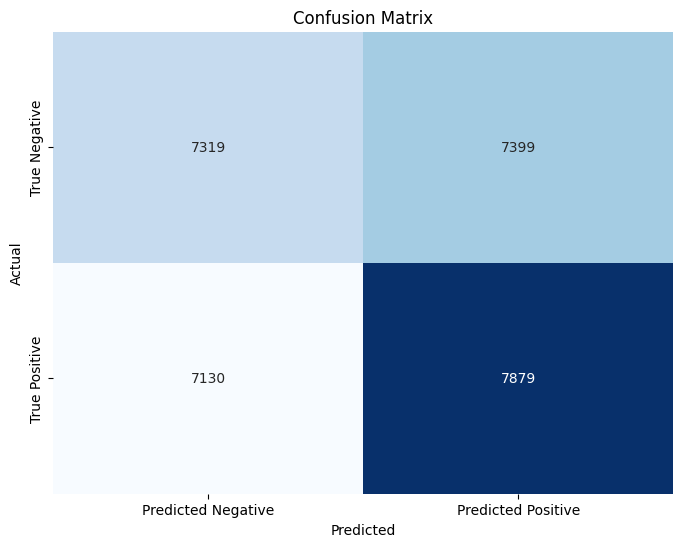

Accuracy: 51.13%


In [11]:
y_pred = (y_pred > 0.5).astype(int) # prediction

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['True Negative', 'True Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.2%}")

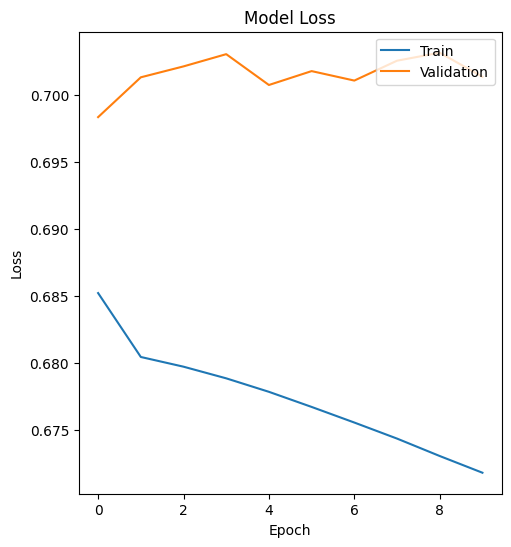

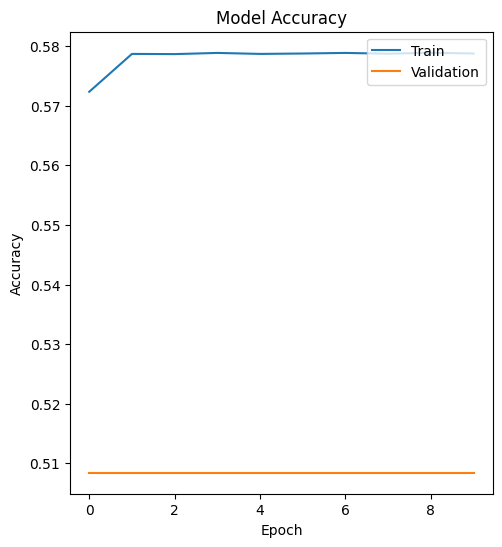

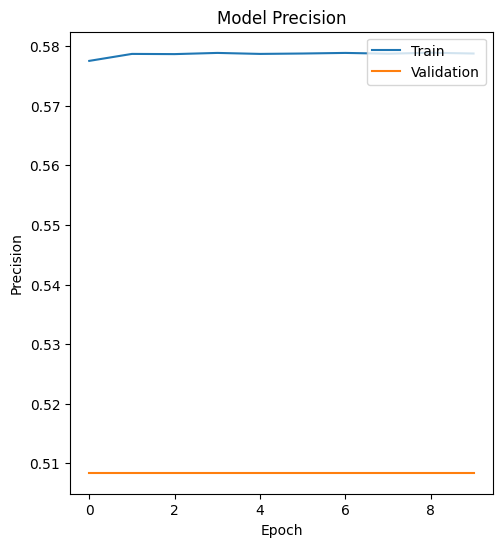

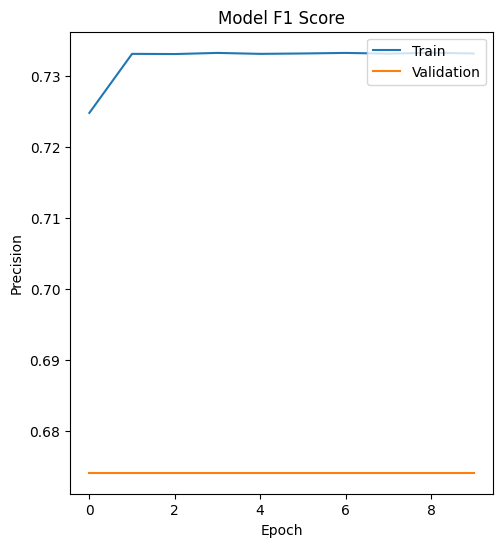

In [14]:
# ===================== PLOT DROWSINESS MODEL =====================
# MODEL LOSS
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(evaluation_result.history['loss'])
plt.plot(evaluation_result.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

# MODEL ACCURACY
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(evaluation_result.history['accuracy'])
plt.plot(evaluation_result.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper right')

# MODEL PRECISION
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(evaluation_result.history['precision'])
plt.plot(evaluation_result.history['val_precision'])
plt.title('Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend(['Train', 'Validation'], loc='upper right')

# MODEL F1 SCORE
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(evaluation_result.history['f1_score'])
plt.plot(evaluation_result.history['val_f1_score'])
plt.title('Model F1 Score')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend(['Train', 'Validation'], loc='upper right')